In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Load the datasets
df_demo = pd.read_csv('df_final_demo.csv')
df_web_data_pt1 = pd.read_csv('df_final_web_data_pt_1.csv')
df_web_data_pt2 = pd.read_csv('df_final_web_data_pt_2.csv')
df_experiment_clients = pd.read_csv('df_final_experiment_clients.csv')

# Combine web data parts
df_web_data = pd.concat([df_web_data_pt1, df_web_data_pt2], ignore_index=True)

# Merge dataframes on client_id
merged_df = df_web_data.merge(df_experiment_clients, on='client_id', how='left')
merged_df = merged_df.merge(df_demo, on='client_id', how='left')

# Convert date_time to datetime format
merged_df['date_time'] = pd.to_datetime(merged_df['date_time'])

# Filter data to the experiment period
start_date = '2017-03-15'
end_date = '2017-04-30'
merged_df = merged_df[(merged_df['date_time'] >= start_date) & (merged_df['date_time'] <= end_date)]

In [2]:
merged_df

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65494,5121453,938663615_6417207175,293028934_22544570787_571525,start,2017-03-29 17:37:37,Control,11.0,140.0,53.0,F,3.0,581602.23,2.0,5.0
65495,5121453,938663615_6417207175,293028934_22544570787_571525,start,2017-03-29 17:37:35,Control,11.0,140.0,53.0,F,3.0,581602.23,2.0,5.0
65496,5121453,938663615_6417207175,293028934_22544570787_571525,start,2017-03-29 17:34:01,Control,11.0,140.0,53.0,F,3.0,581602.23,2.0,5.0
65497,5121453,938663615_6417207175,293028934_22544570787_571525,start,2017-03-29 17:33:38,Control,11.0,140.0,53.0,F,3.0,581602.23,2.0,5.0


1.How do clients interact with the process differently?

<Figure size 1200x700 with 0 Axes>

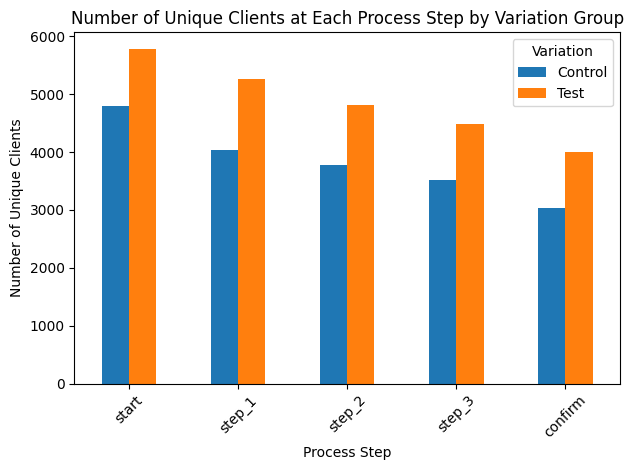

<Figure size 1400x800 with 0 Axes>

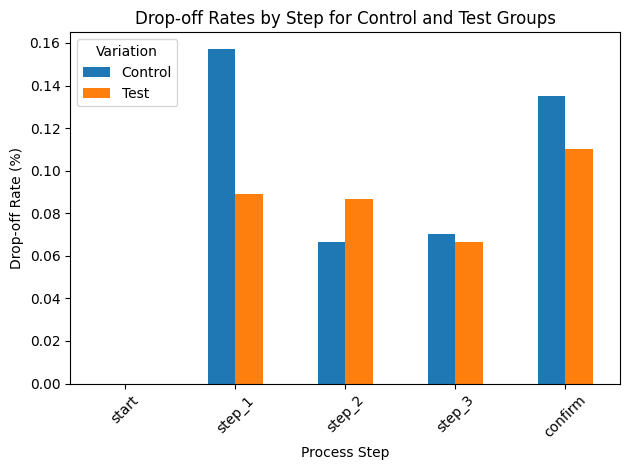

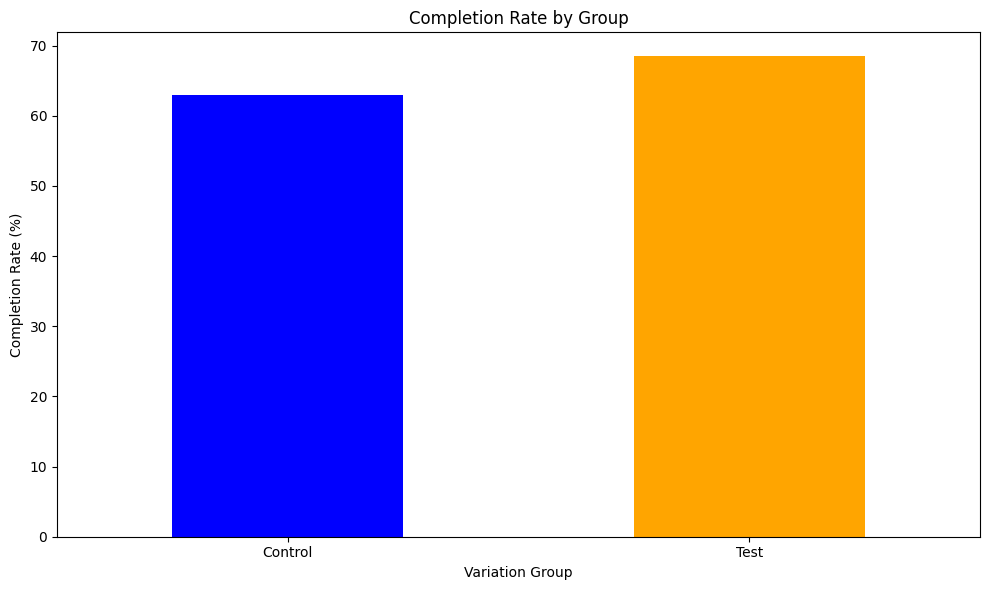

(  process_step Variation  client_id  drop_off_rate
 2        start   Control       4798            NaN
 3        start      Test       5781            NaN
 4       step_1   Control       4044       0.157149
 5       step_1      Test       5267       0.088912
 6       step_2   Control       3776       0.066271
 7       step_2      Test       4810       0.086767
 8       step_3   Control       3510       0.070445
 9       step_3      Test       4491       0.066320
 0      confirm   Control       3036       0.135043
 1      confirm      Test       3997       0.109998,
 Variation
 Control    62.987552
 Test       68.476957
 Name: client_id, dtype: float64)

In [5]:
# Ensure 'confirm' is the last step in the plot by reordering the index
step_counts = merged_df.groupby(['process_step', 'Variation'])['client_id'].nunique().reset_index()

step_counts['process_step'] = pd.Categorical(
    step_counts['process_step'],
    categories=[step for step in step_counts['process_step'].unique() if step != 'confirm'] + ['confirm'],
    ordered=True
)

# Sort the step counts based on the new order
step_counts.sort_values(by='process_step', inplace=True)

# Pivot the data for comparison
step_counts_pivot = step_counts.pivot(index='process_step', columns='Variation', values='client_id')

# Plot the number of clients at each step for control and test groups
plt.figure(figsize=(12, 7))
step_counts_pivot.plot(kind='bar')
plt.title('Number of Unique Clients at Each Process Step by Variation Group')
plt.xlabel('Process Step')
plt.ylabel('Number of Unique Clients')
plt.xticks(rotation=45)
plt.legend(title='Variation')
plt.tight_layout()
plt.show()


# Calculate drop-off rates
step_counts['drop_off_rate'] = step_counts.groupby('Variation')['client_id'].pct_change().abs()
drop_off_analysis = step_counts[['process_step', 'Variation', 'client_id', 'drop_off_rate']]

# Completion rate analysis
completion_counts = merged_df[merged_df['process_step'] == 'confirm'].groupby('Variation')['client_id'].nunique()
total_clients_per_group = merged_df.groupby('Variation')['client_id'].nunique()
completion_rates = (completion_counts / total_clients_per_group) * 100

# Pivot the drop-off analysis data for visualization
drop_off_pivot = drop_off_analysis.pivot(index='process_step', columns='Variation', values='drop_off_rate')

# Plot the drop-off rates for each step and variation group
plt.figure(figsize=(14, 8))
drop_off_pivot.plot(kind='bar')
plt.title('Drop-off Rates by Step for Control and Test Groups')
plt.xlabel('Process Step')
plt.ylabel('Drop-off Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Variation')
plt.tight_layout()
plt.show()

# Plot completion rates for control and test groups
plt.figure(figsize=(10, 6))
completion_rates.plot(kind='bar',color=['blue', 'orange'])
plt.title('Completion Rate by Group')
plt.xlabel('Variation Group')
plt.ylabel('Completion Rate (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Display results
drop_off_analysis, completion_rates

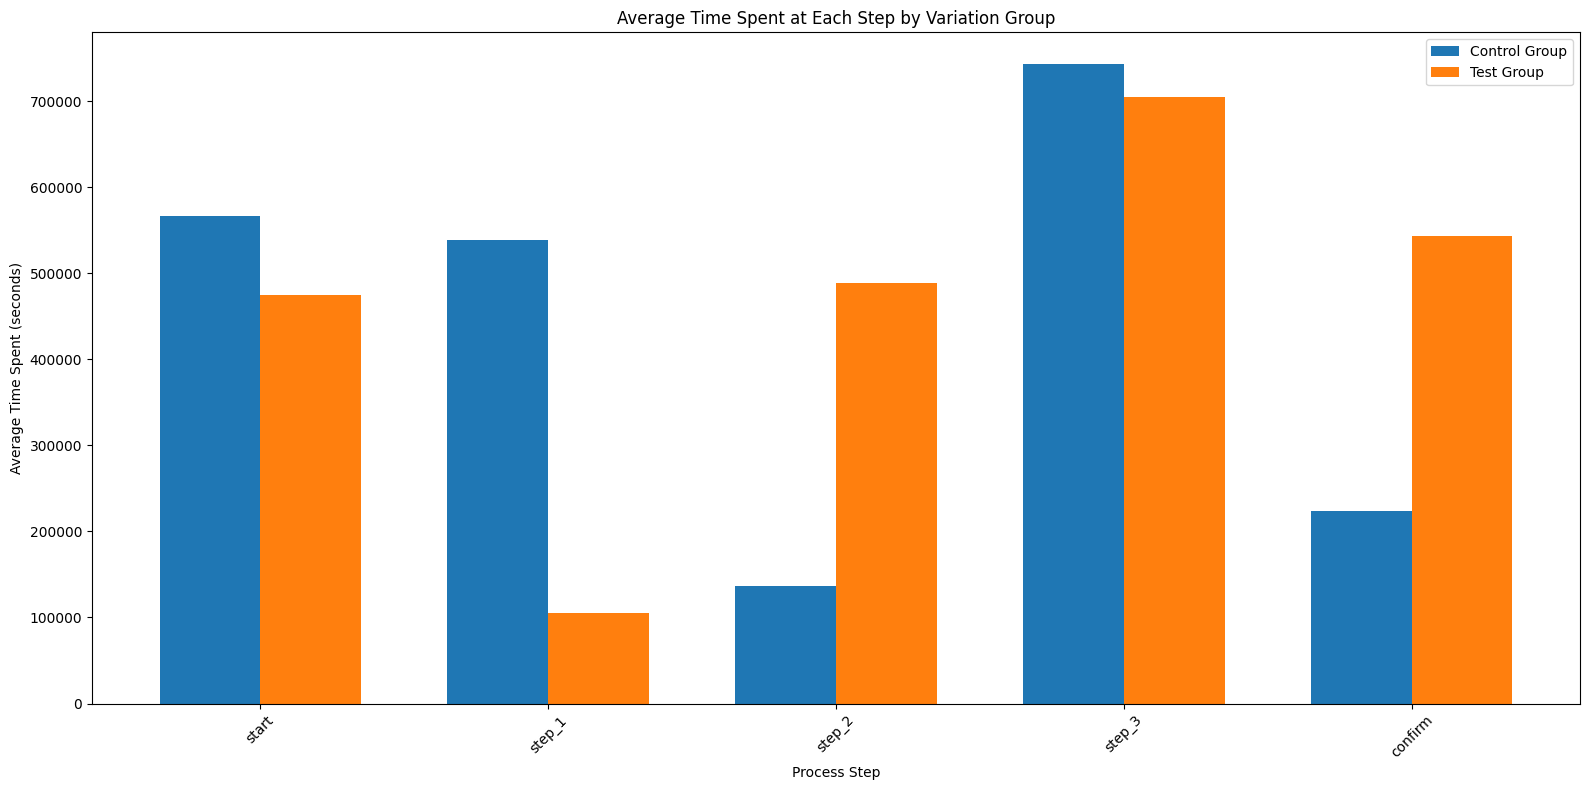

In [6]:
# Calculate average time spent at each step for each variation group
merged_df['next_step_time'] = merged_df.groupby(['client_id', 'Variation'])['date_time'].shift(-1)
merged_df['time_spent'] = (merged_df['next_step_time'] - merged_df['date_time']).dt.total_seconds()

# Filter out negative or missing time_spent values (e.g., last step where no next step exists)
step_time_analysis = merged_df[merged_df['time_spent'] > 0]

# Calculate the average time spent at each step by variation group
average_time_per_step = step_time_analysis.groupby(['process_step', 'Variation'])['time_spent'].mean().reset_index()

# Display average time spent at each step in seconds for each variation group
average_time_per_step.rename(columns={'time_spent': 'average_time_spent_seconds'}, inplace=True)
average_time_per_step.sort_values(by=['process_step', 'Variation'])

# Sort the average time per step to put 'confirm' as the last step for visualization
average_time_per_step['process_step'] = pd.Categorical(
    average_time_per_step['process_step'],
    categories=[step for step in average_time_per_step['process_step'].unique() if step != 'confirm'] + ['confirm'],
    ordered=True
)
average_time_per_step.sort_values(by='process_step', inplace=True)

# Redefine the variations variable and plot again
variations = average_time_per_step['Variation'].unique()

# Create the bar chart with grouped bars in a single chart using matplotlib
plt.figure(figsize=(16, 8))

# Define bar width and positions
bar_width = 0.35
steps = np.arange(len(average_time_per_step['process_step'].unique()))
process_steps = average_time_per_step['process_step'].unique()

# Plot for each variation group
for i, variation in enumerate(variations):
    subset = average_time_per_step[average_time_per_step['Variation'] == variation]
    plt.bar(steps + (i * bar_width), subset['average_time_spent_seconds'], width=bar_width, label=f'{variation} Group')

# Add labels and title
plt.title('Average Time Spent at Each Step by Variation Group')
plt.xlabel('Process Step')
plt.ylabel('Average Time Spent (seconds)')
plt.xticks(steps + bar_width / 2, process_steps, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

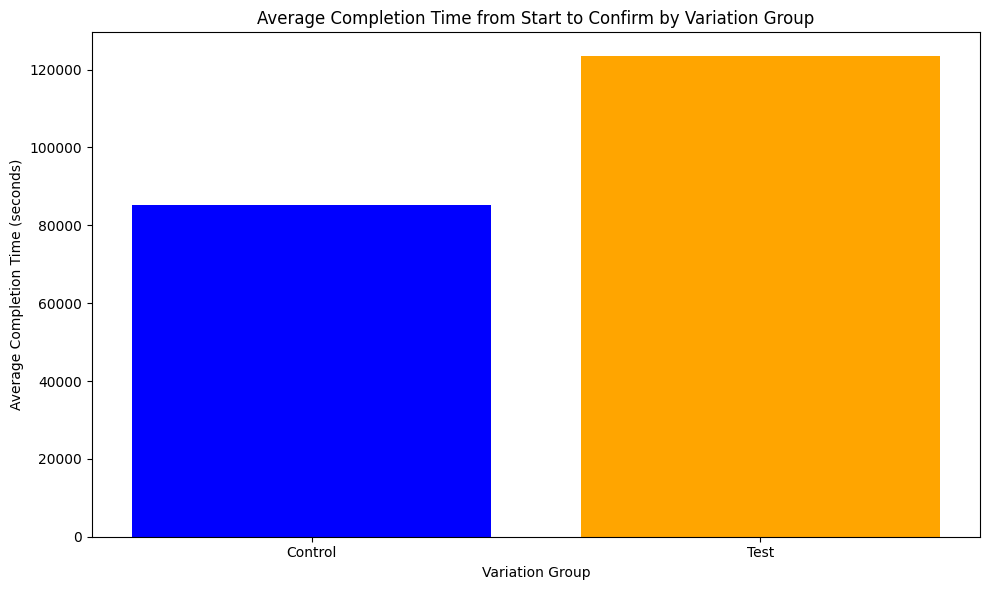

In [7]:
# Calculate time to completion from 'start' to 'confirm' step for each client
start_times = merged_df[merged_df['process_step'] == 'start'].groupby('client_id')['date_time'].min()
confirm_times = merged_df[merged_df['process_step'] == 'confirm'].groupby('client_id')['date_time'].max()

# Merge start and confirm times into a single DataFrame
completion_times_df = pd.merge(start_times, confirm_times, on='client_id', suffixes=('_start', '_confirm'))
completion_times_df['completion_time'] = (completion_times_df['date_time_confirm'] - completion_times_df['date_time_start']).dt.total_seconds()

# Merge with variation information
completion_times_df = completion_times_df.merge(merged_df[['client_id', 'Variation']].drop_duplicates(), on='client_id')

# Calculate average time to completion for each variation group
average_completion_time = completion_times_df.groupby('Variation')['completion_time'].mean()

# Display average completion time in seconds for each variation group
average_completion_time.reset_index(name='average_completion_time_seconds')

# Plot average completion time
plt.figure(figsize=(10, 6))
plt.bar(average_completion_time.index, average_completion_time.values, color=['blue', 'orange'])
plt.title('Average Completion Time from Start to Confirm by Variation Group')
plt.xlabel('Variation Group')
plt.ylabel('Average Completion Time (seconds)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

2.Who currently engages Vanguard via this process?

Demographic Summary of Clients Engaging in the Process:
  Variation  Average Age  Median Age Most Common Gender  \
0   Control    48.271283        49.5                  U   
1      Test    48.533827        50.5                  U   

   Average Number of Accounts  Average Balance  Median Balance  \
0                    2.272183    157979.777004        66238.94   
1                    2.258335    160293.616824        67046.23   

   Average Client Tenure (Years)  
0                      12.040400  
1                      12.111552  


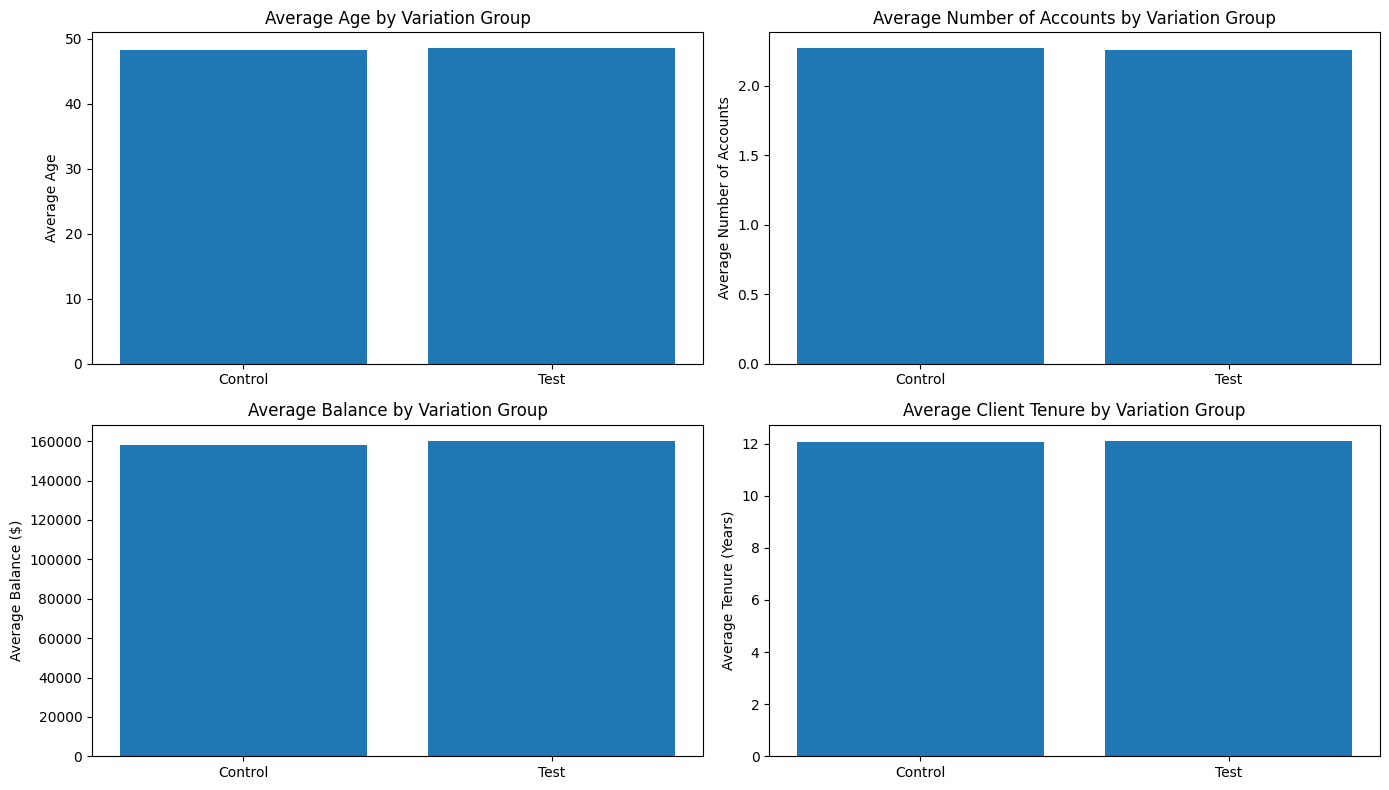

In [9]:
# Analyze the demographic characteristics of clients engaging in the process
# Use demographic data from the merged dataset
demographic_summary = merged_df.groupby('Variation').agg({
    'clnt_age': ['mean', 'median'],
    'gendr': lambda x: x.value_counts().index[0],  # Most common gender
    'num_accts': 'mean',
    'bal': ['mean', 'median'],
    'clnt_tenure_yr': 'mean'
}).reset_index()

# Rename columns for readability
demographic_summary.columns = [
    'Variation',
    'Average Age',
    'Median Age',
    'Most Common Gender',
    'Average Number of Accounts',
    'Average Balance',
    'Median Balance',
    'Average Client Tenure (Years)'
]

# Display the demographic summary in the console
print("Demographic Summary of Clients Engaging in the Process:")
print(demographic_summary)

# Visualize some key demographic characteristics
plt.figure(figsize=(14, 8))

# Average Age
plt.subplot(2, 2, 1)
plt.bar(demographic_summary['Variation'], demographic_summary['Average Age'])
plt.title('Average Age by Variation Group')
plt.ylabel('Average Age')

# Average Number of Accounts
plt.subplot(2, 2, 2)
plt.bar(demographic_summary['Variation'], demographic_summary['Average Number of Accounts'])
plt.title('Average Number of Accounts by Variation Group')
plt.ylabel('Average Number of Accounts')

# Average Balance
plt.subplot(2, 2, 3)
plt.bar(demographic_summary['Variation'], demographic_summary['Average Balance'])
plt.title('Average Balance by Variation Group')
plt.ylabel('Average Balance ($)')

# Average Client Tenure
plt.subplot(2, 2, 4)
plt.bar(demographic_summary['Variation'], demographic_summary['Average Client Tenure (Years)'])
plt.title('Average Client Tenure by Variation Group')
plt.ylabel('Average Tenure (Years)')

plt.tight_layout()
plt.show()

3.For the experimental new process, how can its success be measured?

4.How did the new process perform?

5.How effective was the experiment design?

In [11]:
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact

# Group balance analysis: descriptive statistics
group_balance = merged_df.groupby('Variation').agg({
    'clnt_age': ['mean', 'std'],
    'clnt_tenure_yr': ['mean', 'std'],
    'num_accts': ['mean', 'std'],
    'bal': ['mean', 'std']
}).reset_index()

# Perform t-tests for key demographic variables to ensure group similarity
control_group = merged_df[merged_df['Variation'] == 'Control']
test_group = merged_df[merged_df['Variation'] == 'Test']

# Check for missing data before running t-tests
control_group_cleaned = control_group[['clnt_age', 'clnt_tenure_yr', 'num_accts', 'bal']].dropna()
test_group_cleaned = test_group[['clnt_age', 'clnt_tenure_yr', 'num_accts', 'bal']].dropna()

# Perform t-tests
age_ttest = ttest_ind(control_group_cleaned['clnt_age'], test_group_cleaned['clnt_age'], equal_var=False)
tenure_ttest = ttest_ind(control_group_cleaned['clnt_tenure_yr'], test_group_cleaned['clnt_tenure_yr'], equal_var=False)
accounts_ttest = ttest_ind(control_group_cleaned['num_accts'], test_group_cleaned['num_accts'], equal_var=False)
balance_ttest = ttest_ind(control_group_cleaned['bal'], test_group_cleaned['bal'], equal_var=False)

# Completion rates analysis using the 'confirm' step
completion_counts = merged_df[merged_df['process_step'] == 'confirm'].groupby('Variation')['client_id'].nunique()
total_clients_per_group = merged_df.groupby('Variation')['client_id'].nunique()
completion_rates = (completion_counts / total_clients_per_group) * 100

# Chi-square test for completion rates or Fisher's exact test if needed
completed_control = completion_counts.get('Control', 0)
completed_test = completion_counts.get('Test', 0)
not_completed_control = total_clients_per_group.get('Control', 0) - completed_control
not_completed_test = total_clients_per_group.get('Test', 0) - completed_test

# Check if chi-square test can be performed
if completed_control > 0 and completed_test > 0 and not_completed_control > 0 and not_completed_test > 0:
    chi2, p, dof, ex = chi2_contingency([[completed_control, not_completed_control],
                                         [completed_test, not_completed_test]])
    chi_square_result = {'Chi2': chi2, 'p-value': p, 'Degrees of Freedom': dof}
else:
    # Use Fisher's exact test for small sample sizes or when counts are zero
    contingency_matrix = [[completed_control, not_completed_control], [completed_test, not_completed_test]]
    odds_ratio, fisher_p = fisher_exact(contingency_matrix, alternative='two-sided')
    chi_square_result = {'Fisher p-value': fisher_p, 'Odds Ratio': odds_ratio}

# Return results for review
(group_balance,
 {'Age T-test p-value': age_ttest.pvalue,
  'Tenure T-test p-value': tenure_ttest.pvalue,
  'Accounts T-test p-value': accounts_ttest.pvalue,
  'Balance T-test p-value': balance_ttest.pvalue},
 completion_rates,
 chi_square_result)

(  Variation   clnt_age            clnt_tenure_yr           num_accts  \
                   mean        std           mean       std      mean   
 0   Control  48.271283  15.456956      12.040400  6.938368  2.272183   
 1      Test  48.533827  15.804042      12.111552  6.882132  2.258335   
 
                        bal                 
         std           mean            std  
 0  0.542526  157979.777004  294522.781016  
 1  0.536240  160293.616824  384639.227680  ,
 {'Age T-test p-value': 0.03506962212839524,
  'Tenure T-test p-value': 0.19738405502294692,
  'Accounts T-test p-value': 0.0013134603075116945,
  'Balance T-test p-value': 0.38785553880806445},
 Variation
 Control    62.987552
 Test       68.476957
 Name: client_id, dtype: float64,
 {'Chi2': 35.20396130392208,
  'p-value': 2.9691897152667635e-09,
  'Degrees of Freedom': 1})

6.Was the experiment run long enough?

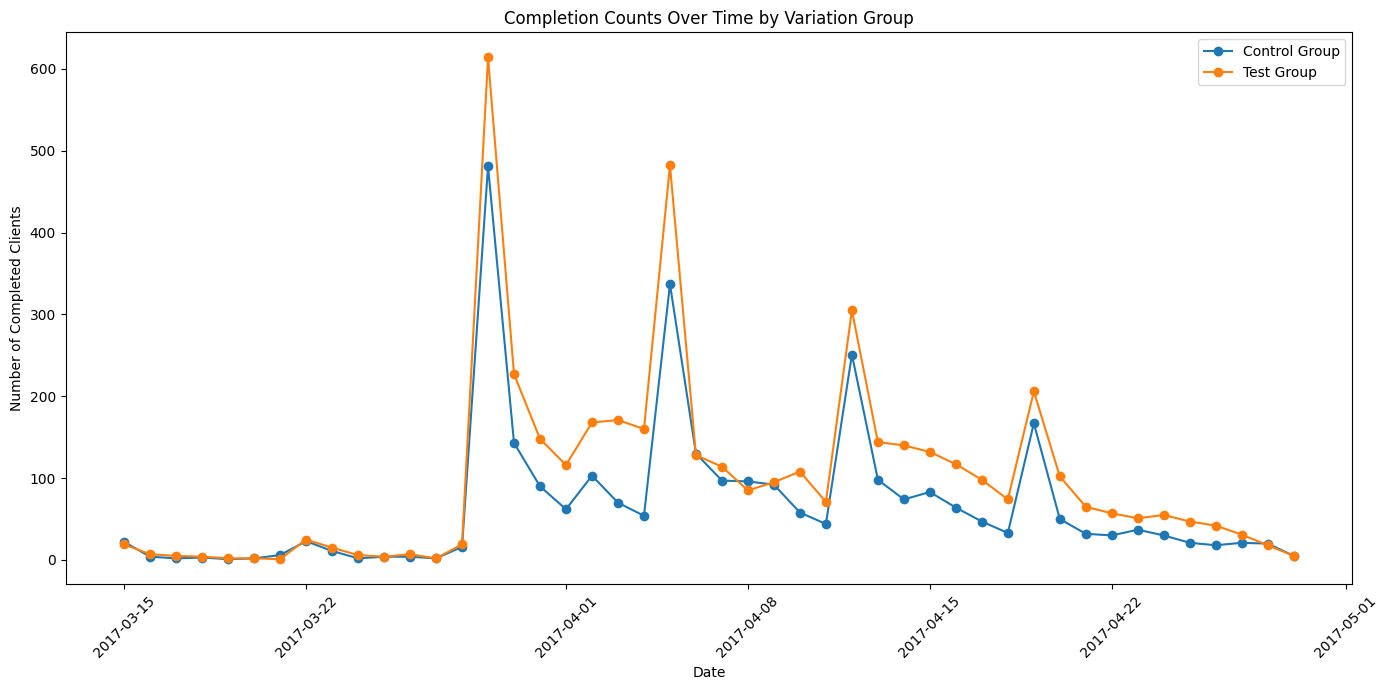

(0.9998950941572672, 2604.6896766102072)

In [12]:
import matplotlib.pyplot as plt
from statsmodels.stats.power import GofChisquarePower

# Check trends in completion rates over time
merged_df['date'] = merged_df['date_time'].dt.date
completion_trends = merged_df[merged_df['process_step'] == 'confirm'].groupby(['date', 'Variation'])['client_id'].nunique().reset_index()

# Plot completion counts over time
plt.figure(figsize=(14, 7))
for variation in completion_trends['Variation'].unique():
    subset = completion_trends[completion_trends['Variation'] == variation]
    plt.plot(subset['date'], subset['client_id'], marker='o', label=f'{variation} Group')

plt.title('Completion Counts Over Time by Variation Group')
plt.xlabel('Date')
plt.ylabel('Number of Completed Clients')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate observed power for the chi-square test
effect_size = (completion_rates['Test'] - completion_rates['Control']) / 100  # Approximate effect size as the difference in proportions
sample_size = total_clients_per_group.sum()
power_analysis = GofChisquarePower()
observed_power = power_analysis.solve_power(effect_size=effect_size, nobs=sample_size, alpha=0.05, power=None)
# Calculate required sample size for 80% power
required_sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.80, nobs=None)

observed_power, required_sample_size

7.How can the performance of the process be evaluated?

In [13]:
# Calculate the average number of logins per user by variation group
logins_per_user = merged_df.groupby('Variation')['logons_6_mnth'].mean()
print("Average Number of Logins by Variation Group:")
print(logins_per_user)

# Calculate the average number of page views per user by counting unique process steps
page_views_per_user = merged_df.groupby(['client_id', 'Variation'])['process_step'].nunique().groupby('Variation').mean()
print("\nAverage Number of Page Views per User by Variation Group:")
print(page_views_per_user)

Average Number of Logins by Variation Group:
Variation
Control    6.238615
Test       6.178532
Name: logons_6_mnth, dtype: float64

Average Number of Page Views per User by Variation Group:
Variation
Control    3.975934
Test       4.170978
Name: process_step, dtype: float64


In [23]:
# Calculate completion rate by age group and variation with observed=True to handle categories properly
# Create age groups for cohort analysis
merged_df['age_group'] = pd.cut(merged_df['clnt_age'], bins=[0, 30, 45, 60, 75, 100], labels=['<30', '30-45', '45-60', '60-75', '>75'])

cohort_completion_rate = (
    merged_df[merged_df['process_step'] == 'confirm']
    .groupby(['age_group', 'Variation'], observed=True)['client_id'].nunique() /
    merged_df.groupby(['age_group', 'Variation'], observed=True)['client_id'].nunique()
)

# Display cohort completion rate analysis by age group
cohort_completion_rate.reset_index(name='completion_rate').dropna()

,age_group,Variation,completion_rate
0,<30,Control,0.619617
1,<30,Test,0.729187
2,30-45,Control,0.656447
3,30-45,Test,0.706289
4,45-60,Control,0.648172
5,45-60,Test,0.664814
6,60-75,Control,0.606495
7,60-75,Test,0.658927
8,>75,Control,0.404580
9,>75,Test,0.601307


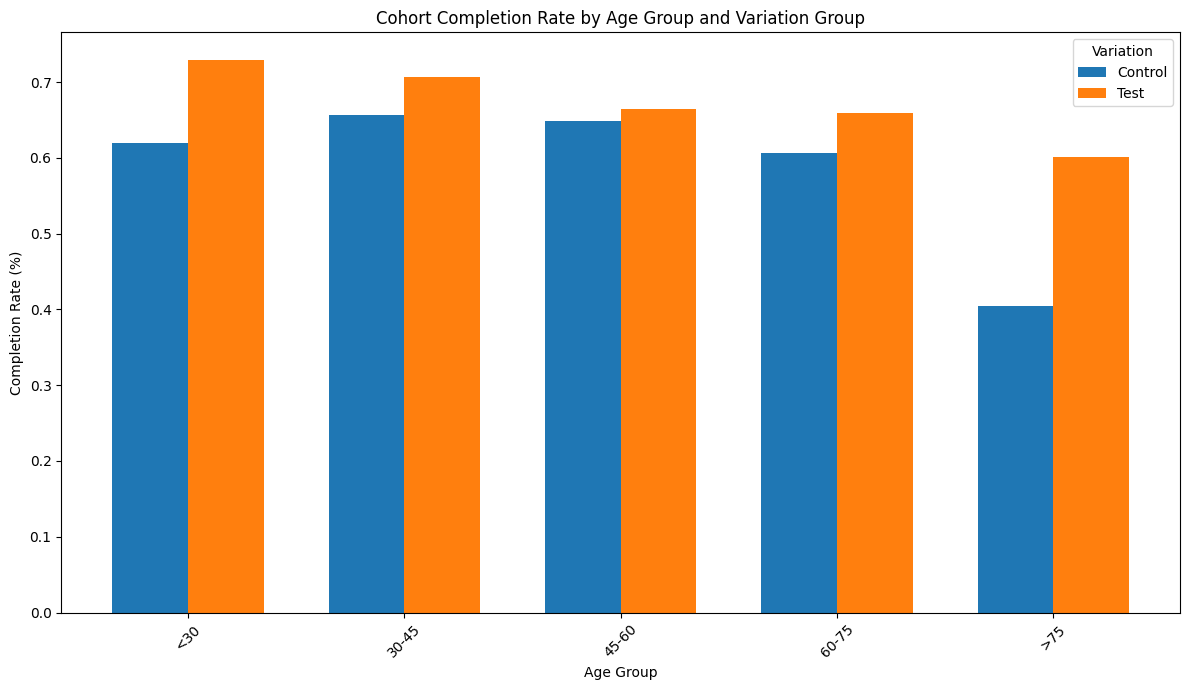

In [22]:
# Reset index for cohort completion rate
cohort_completion_rate_df = cohort_completion_rate.reset_index(name='completion_rate')

# Define bar width and positions
bar_width = 0.35
age_groups = cohort_completion_rate_df['age_group'].unique()
x = np.arange(len(age_groups))

# Create the plot
plt.figure(figsize=(12, 7))

# Plotting control and test groups side by side
for i, variation in enumerate(cohort_completion_rate_df['Variation'].unique()):
    subset = cohort_completion_rate_df[cohort_completion_rate_df['Variation'] == variation]
    plt.bar(x + i * bar_width, subset['completion_rate'], width=bar_width, label=variation)

# Add labels, title, and legend
plt.title('Cohort Completion Rate by Age Group and Variation Group')
plt.xlabel('Age Group')
plt.ylabel('Completion Rate (%)')
plt.xticks(x + bar_width / 2, age_groups, rotation=45)
plt.legend(title='Variation')
plt.tight_layout()
plt.show()

8.What other data may be required and/or helpful to the analysis?

In [ ]:
# Identify the conversion step after 'confirm' for analysis
# Here, assume a conversion action step follows 'confirm', e.g., 'enroll' or similar
conversion_step = 'enroll'  # Replace with actual step name if different

# Calculate the number of users who performed the conversion step by variation
conversion_counts = merged_df[merged_df['process_step'] == conversion_step].groupby('Variation')['client_id'].nunique()

# Calculate conversion rate relative to users who completed the 'confirm' step
conversion_rates = (conversion_counts / completion_counts) * 100

# Display conversion metrics
conversion_rates.reset_index(name='conversion_rate').dropna()